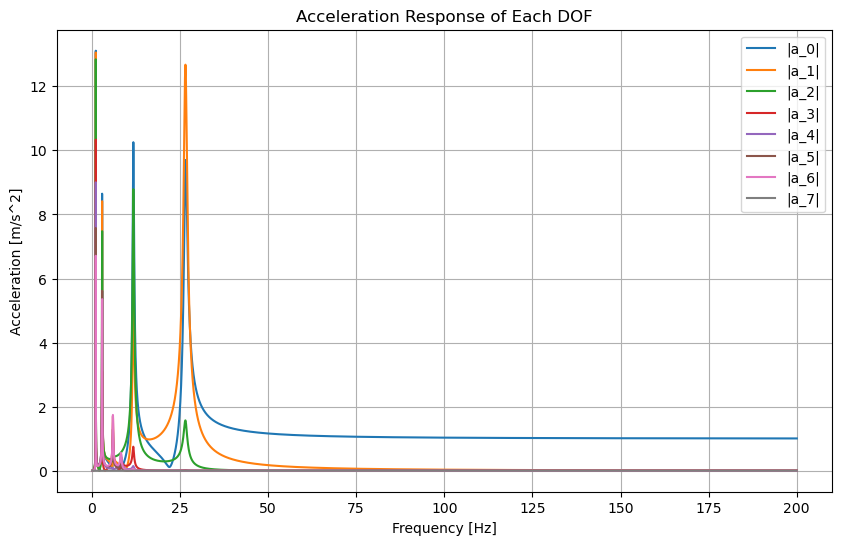

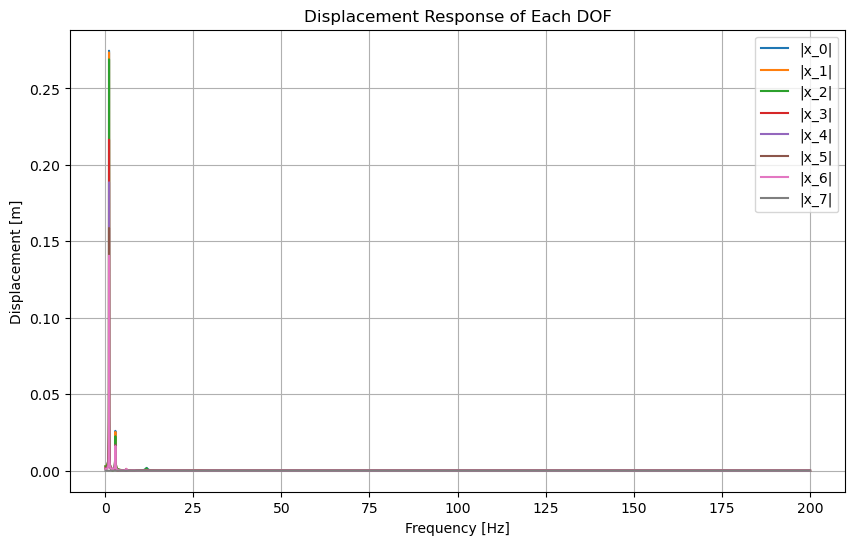

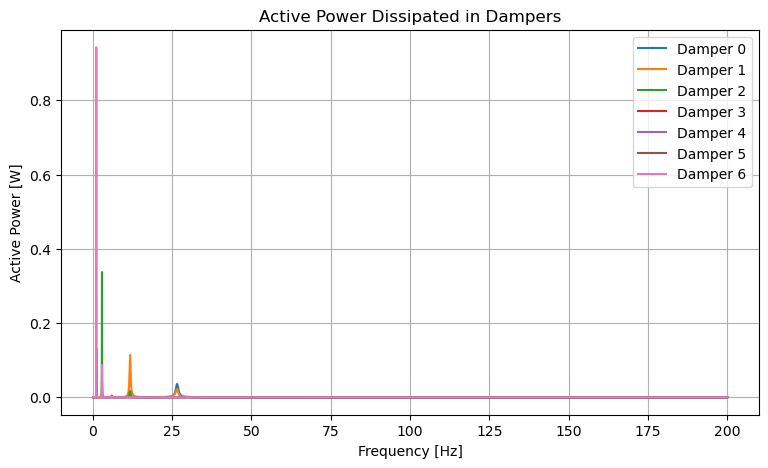

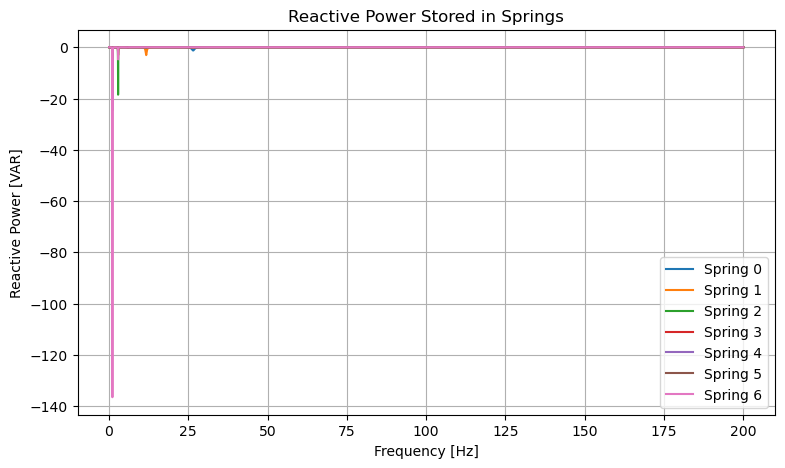

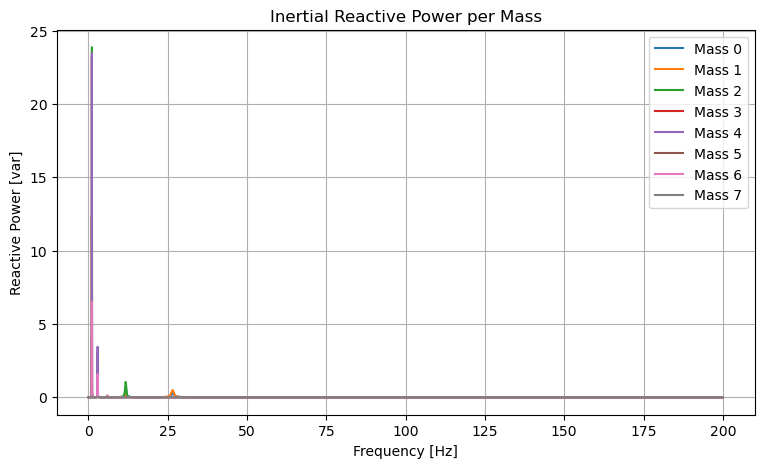

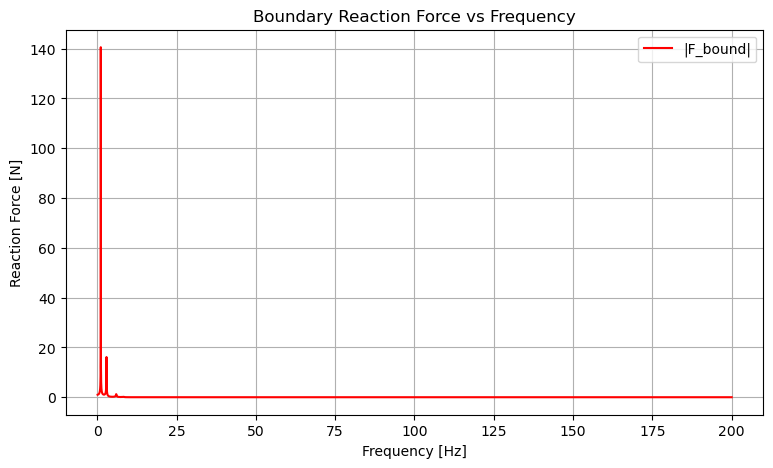

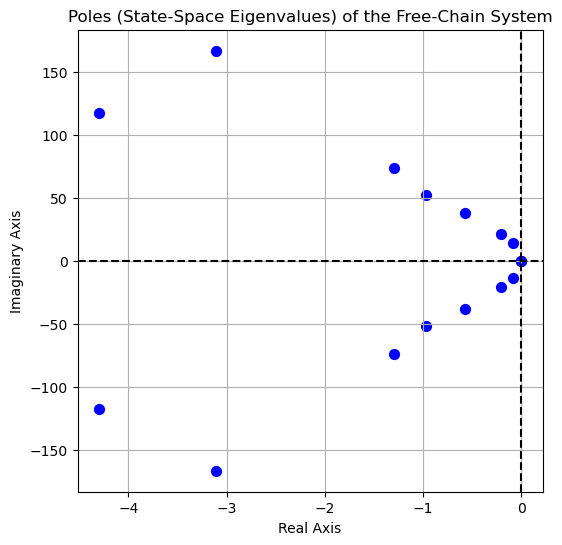


Undamped Natural Frequencies (Hz):
  Mode 1: 0.000 Hz
  Mode 2: 2.218 Hz
  Mode 3: 3.354 Hz
  Mode 4: 6.076 Hz
  Mode 5: 8.282 Hz
  Mode 6: 11.750 Hz
  Mode 7: 18.716 Hz
  Mode 8: 26.553 Hz

Mode 1 at 0.000 Hz
  Total Kinetic Energy: 0.0000 J
  Total Potential Energy: 0.0000 J
  Kinetic Energy Distribution: [5.51193875e-15 5.51193875e-15 1.10238775e-14 1.65358163e-14
 2.20477550e-14 5.51193875e-15 1.10238775e-14 1.65358163e-14]
  Potential Energy Distribution: [4.16000868e-29 5.77778983e-29 3.01985815e-28 1.15555797e-30
 2.60385728e-28 2.18400456e-28 1.54074396e-30]

Mode 2 at 2.218 Hz
  Total Kinetic Energy: 97.0702 J
  Total Potential Energy: 97.0702 J
  Kinetic Energy Distribution: [14.05841581 13.60721117 23.77903446  1.32753593  0.61328802  1.22795147
  4.42152234 38.03521379]
  Potential Energy Distribution: [ 0.22744214  1.79021907 39.89147417 17.257347   10.57929679  5.17188513
 22.15250869]

Mode 3 at 3.354 Hz
  Total Kinetic Energy: 222.0942 J
  Total Potential Energy: 222.0

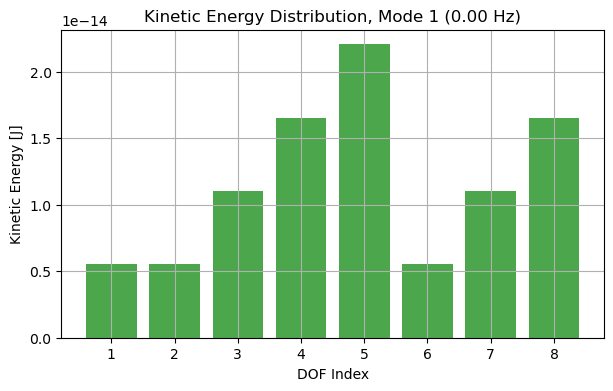

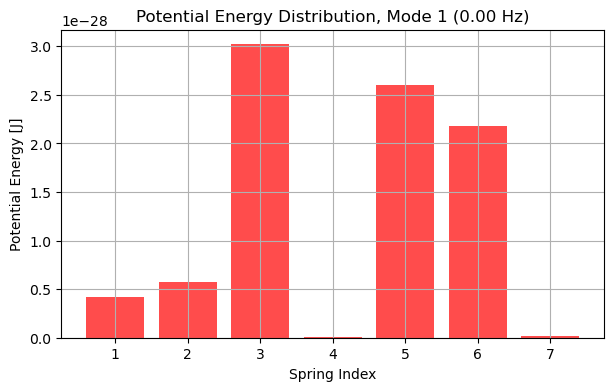

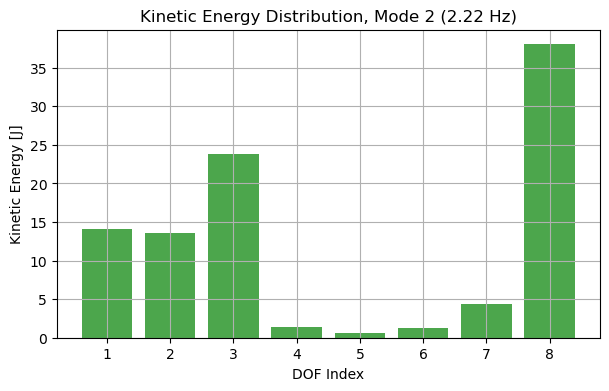

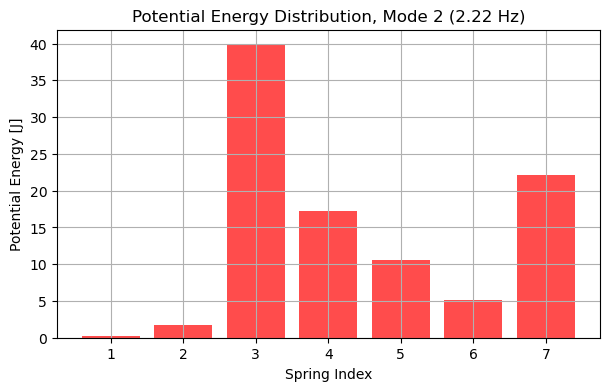

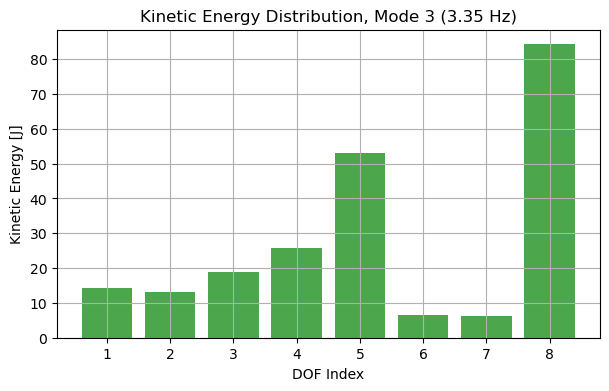

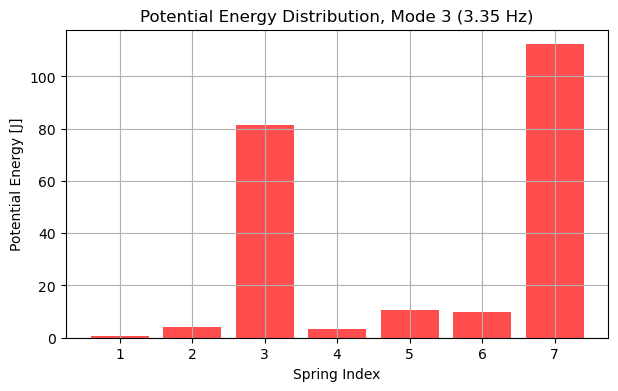

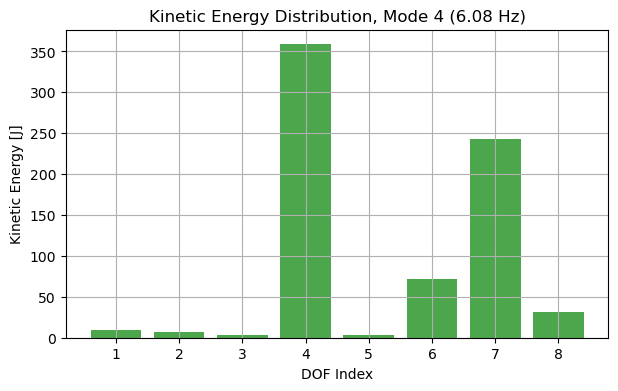

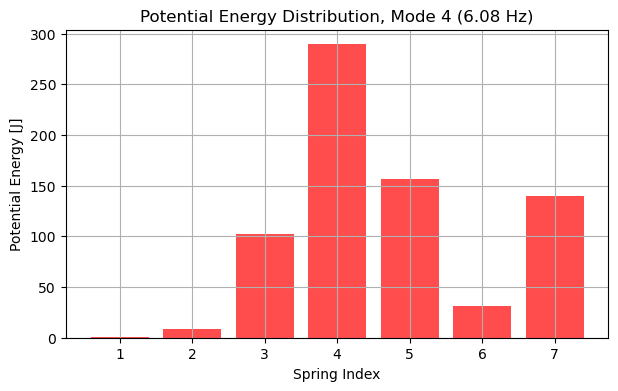

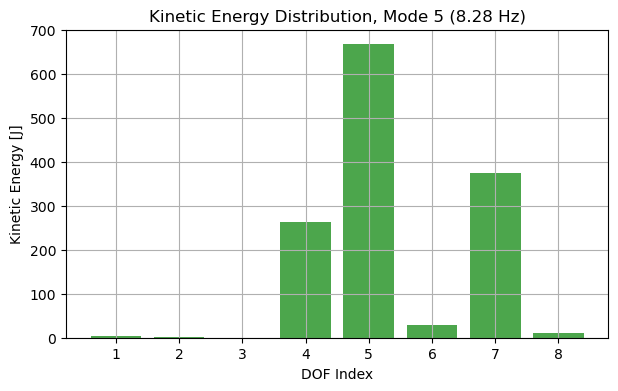

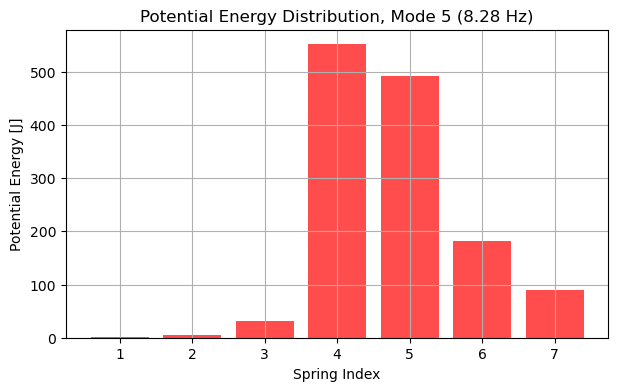

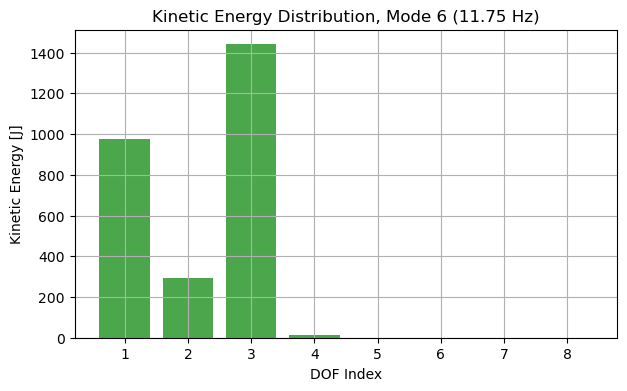

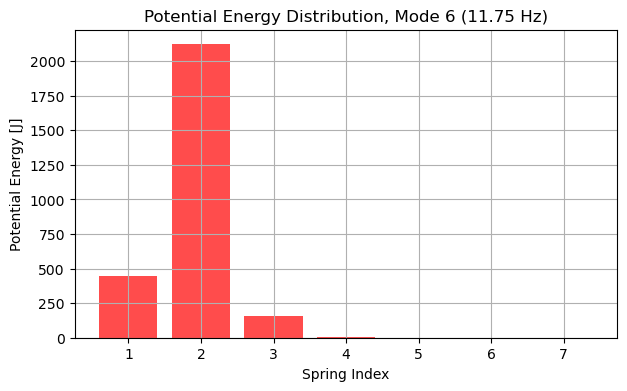

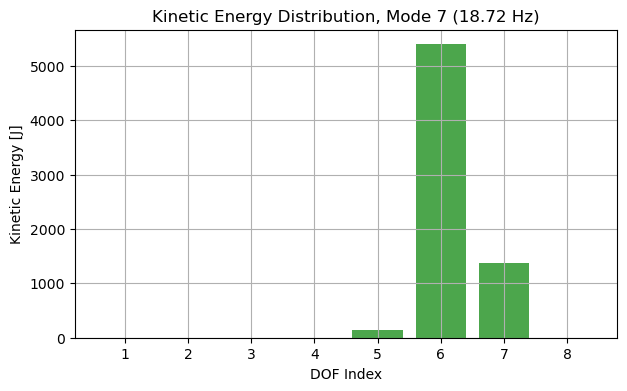

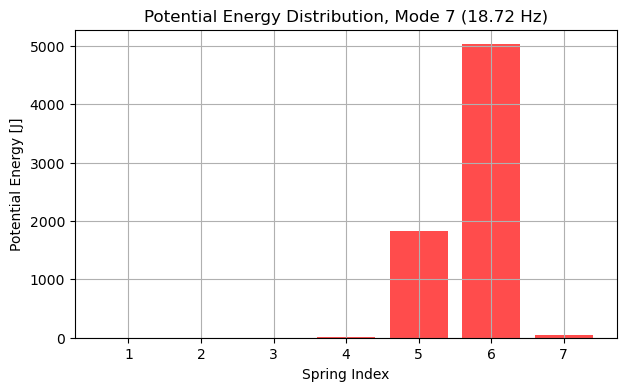

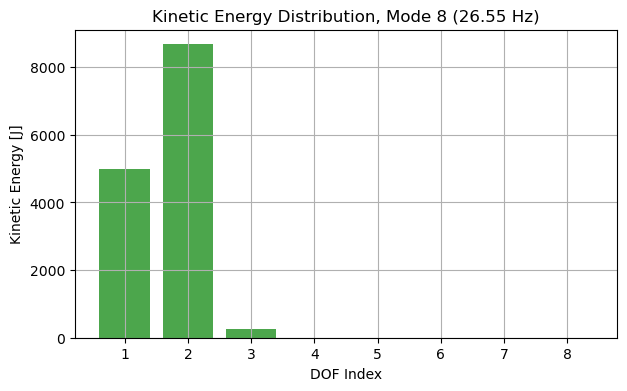

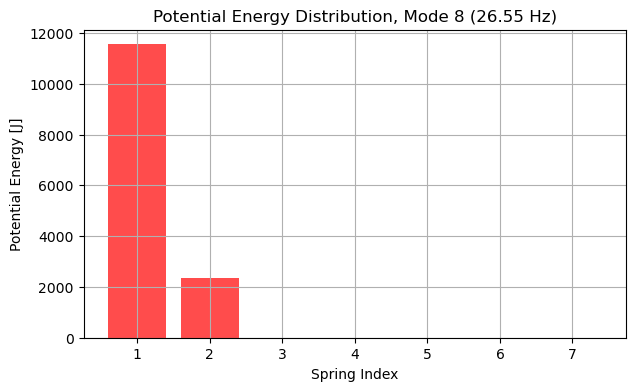


Analysis complete.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, eig

###############################################################################
# SYSTEM MATRIX BUILDING FUNCTIONS (Free-Chain, No Ground Connection)
###############################################################################
def build_free_chain_matrices(m, c_inter, k_inter):
    """
    Build free-chain (N x N) mass, damping, and stiffness matrices using only 
    inter-DOF connections (no ground attachment). Here, m is an array of masses,
    and c_inter and k_inter are arrays (length N-1) of interconnection damping and stiffness.
    """
    N = len(m)
    M = np.diag(m)
    C = np.zeros((N, N))
    K = np.zeros((N, N))
    for i in range(N - 1):
        # Damping: affects DOF i and i+1
        C[i, i]     += c_inter[i]
        C[i, i+1]   -= c_inter[i]
        C[i+1, i]   -= c_inter[i]
        C[i+1, i+1] += c_inter[i]
        # Stiffness: affects DOF i and i+1
        K[i, i]     += k_inter[i]
        K[i, i+1]   -= k_inter[i]
        K[i+1, i]   -= k_inter[i]
        K[i+1, i+1] += k_inter[i]
    return M, C, K

###############################################################################
# AUGMENTED SYSTEM FORCED RESPONSE (Enforcing a Boundary Condition)
###############################################################################
def build_augmented_system(D, F_ext):
    """
    Given the dynamic stiffness matrix D (N x N) and external force vector F_ext (length N),
    build the augmented (N+1) x (N+1) system to enforce the boundary condition x_{N-1} = 0.
    
    The augmented unknown vector is:
      [ x_0, x_1, ..., x_{N-1}, F_bound ]^T
    where F_bound is the unknown reaction force.
    
    The equations become:
      D*x - e_{N-1} * F_bound = F_ext,  (for DOFs)
      x_{N-1} = 0.                      (constraint)
    """
    N = D.shape[0]
    A_aug = np.zeros((N+1, N+1), dtype=complex)
    b_aug = np.zeros(N+1, dtype=complex)
    
    # Top-left N x N block is D.
    A_aug[0:N, 0:N] = D
    # The reaction force only enters the equation for DOF (N-1)
    A_aug[N-1, N] = -1.0
    # Right-hand side for the top N rows is F_ext.
    b_aug[0:N] = F_ext
    # The last row enforces x_{N-1} = 0.
    A_aug[N, N-1] = 1.0
    # b_aug[N] is 0 by default.
    return A_aug, b_aug

def compute_forced_response_free_chain(m, c_inter, k_inter, f_vals, F_ext):
    """
    Compute the forced response for a free-chain system using the augmented formulation.
    Returns:
      X: Displacement solutions (shape: N x len(f_vals))
      F_bound: Reaction force at the constrained DOF (array of length len(f_vals))
    """
    N = len(m)
    num_points = len(f_vals)
    X = np.zeros((N, num_points), dtype=complex)
    F_bound = np.zeros(num_points, dtype=complex)
    
    # Build free-chain matrices (without ground attachment)
    M, C, K = build_free_chain_matrices(m, c_inter, k_inter)
    
    for i, f in enumerate(f_vals):
        w = 2 * np.pi * f
        # Dynamic stiffness matrix: D = K + j*w*C - w^2*M
        D = K + 1j*w*C - (w**2)*M
        # Build the augmented system to enforce x_{N-1} = 0.
        A_aug, b_aug = build_augmented_system(D, F_ext)
        sol = np.linalg.solve(A_aug, b_aug)
        X[:, i] = sol[0:N]      # Displacements
        F_bound[i] = sol[N]       # Reaction force at the boundary
    return X, F_bound

###############################################################################
# POLE CALCULATION (State-Space Eigenvalues)
###############################################################################
def compute_poles_free_chain(m, c_inter, k_inter):
    """
    Compute the poles (state-space eigenvalues) of the free-chain system.
    For the N-DOF system, form the state-space matrix:
      A = [ 0        I ]
          [ -M^{-1}K  -M^{-1}C ]
    and compute its eigenvalues.
    """
    M, C, K = build_free_chain_matrices(m, c_inter, k_inter)
    N = len(m)
    zero_block = np.zeros((N, N))
    I_block = np.eye(N)
    Minv = np.linalg.inv(M)
    
    A_upper = np.hstack((zero_block, I_block))
    A_lower = np.hstack((-Minv @ K, -Minv @ C))
    A = np.vstack((A_upper, A_lower))
    
    poles, _ = eig(A)
    return poles

###############################################################################
# FREE-VIBRATION ANALYSIS AND MODAL ENERGY DISTRIBUTION
###############################################################################
def free_vibration_analysis_free_chain(m, k_inter):
    """
    Perform undamped free-vibration analysis for the free-chain system.
    Constructs the free-chain mass and stiffness matrices and solves the generalized
    eigenvalue problem. Returns:
      f_n: natural frequencies (Hz)
      eigvecs: mode shapes (each column is a mode)
      M, K: the mass and stiffness matrices used
    """
    N = len(m)
    M, _, K = build_free_chain_matrices(m, np.zeros(N-1), k_inter)
    eigvals, eigvecs = eigh(K, M)
    # Convert eigenvalues to natural frequencies (Hz)
    omega_n = np.sqrt(eigvals)
    f_n = omega_n / (2*np.pi)
    return f_n, eigvecs, M, K

def modal_energy_analysis(m, k_inter, f_n, eigvecs, M):
    """
    Compute modal energy distribution for each mode of the free-chain.
    For each eigenmode, the mode shape is mass-normalized (phi^T M phi = 1).
    Then the kinetic energy (per DOF) is computed from T_dof = 0.5 * m * (omega * |phi|)^2,
    and the potential energy in each spring is computed from the difference in mode shape values.
    
    Returns a list of dictionaries containing energy data for each mode.
    """
    N = len(m)
    modal_energies = []
    for i in range(eigvecs.shape[1]):
        phi = eigvecs[:, i]
        # Normalize such that phi^T M phi = 1
        norm_factor = np.sqrt(np.real(np.conjugate(phi).T @ M @ phi))
        phi_norm = phi / norm_factor
        omega_i = 2*np.pi*f_n[i]
        
        # Kinetic energy distribution per DOF
        T_dof = 0.5 * m * (omega_i * np.abs(phi_norm))**2
        T_total = np.sum(T_dof)
        
        # Potential energy distribution per spring (between adjacent DOFs)
        V_springs = np.zeros(N-1)
        for s in range(N-1):
            V_springs[s] = 0.5 * k_inter[s] * (np.abs(phi_norm[s+1] - phi_norm[s]))**2
        V_total = np.sum(V_springs)
        
        modal_energies.append({
            'mode': i+1,
            'omega_rad_s': omega_i,
            'T_total': T_total,
            'V_total': V_total,
            'T_dof': T_dof,
            'V_springs': V_springs,
            'phi_norm': phi_norm
        })
    return modal_energies

###############################################################################
# POST-PROCESSING OF FORCED RESPONSE: ACCELERATION, TRANSMISSIBILITY,
# ACTIVE/REACTIVE POWER, and OPTIONAL INERTIAL REACTIVE POWER (per mass)
###############################################################################
def forced_response_postprocessing(m, c_inter, k_inter, f_vals, F_ext):
    """
    Computes the forced response using the augmented formulation and then derives:
      - Acceleration (a = -w^2*x)
      - A transmissibility measure (here simply plotting displacement amplitudes)
      - Active and reactive power in the inter-DOF (spring/damper) connections
      - Inertial reactive power per mass: Q_mass = 0.5 * w * m * |V|^2  (from Code 2)
    
    Returns a dictionary containing:
      X_vals: Displacement (N x num_points)
      A_vals: Acceleration (N x num_points)
      P_damp: Active power in dampers ( (N-1) x num_points )
      P_spring: Reactive power in springs ( (N-1) x num_points )
      Q_mass: Inertial reactive power per mass (N x num_points)
      F_bound: Reaction force from the augmented system (num_points,)
    """
    N = len(m)
    num_points = len(f_vals)
    X_vals = np.zeros((N, num_points), dtype=complex)
    A_vals = np.zeros((N, num_points), dtype=complex)
    P_damp = np.zeros((N-1, num_points), dtype=complex)
    P_spring = np.zeros((N-1, num_points), dtype=complex)
    Q_mass = np.zeros((num_points, N))
    F_bound_array = np.zeros(num_points, dtype=complex)
    
    # Build free-chain matrices (for the unconstrained system)
    M, C, K = build_free_chain_matrices(m, c_inter, k_inter)
    
    for i, f in enumerate(f_vals):
        w = 2 * np.pi * f
        # Dynamic stiffness for free chain
        D = K + 1j*w*C - (w**2)*M
        # Augmented system to enforce x_{N-1} = 0
        A_aug, b_aug = build_augmented_system(D, F_ext)
        sol = np.linalg.solve(A_aug, b_aug)
        X = sol[0:N]
        F_bound_array[i] = sol[N]
        X_vals[:, i] = X
        
        # Compute acceleration (a = -w^2*x)
        A_vals[:, i] = -w**2 * X
        
        # Compute velocity V = j*w*x for power calculations
        V = 1j * w * X
        
        # For each inter-DOF connection (from DOF i-1 to DOF i)
        for j in range(1, N):
            X_rel = X[j] - X[j-1]
            V_rel = V[j] - V[j-1]
            # Damping (active) power: P_active = c * |V_rel|^2
            P_damp[j-1, i] = c_inter[j-1] * (V_rel * np.conjugate(V_rel))
            # Spring (reactive) power: P_reactive = k * X_rel * conj(V_rel)
            P_spring[j-1, i] = k_inter[j-1] * (X_rel * np.conjugate(V_rel))
        
        # Inertial reactive power per mass (as in Code 2): Q = 0.5 * w * m * |V|^2
        Q_mass[i, :] = 0.5 * w * m * (np.abs(V)**2)
    
    return {
        'X_vals': X_vals,
        'A_vals': A_vals,
        'P_damp': P_damp,
        'P_spring': P_spring,
        'Q_mass': Q_mass,
        'F_bound': F_bound_array
    }

###############################################################################
# MAIN SCRIPT
###############################################################################
def main():
    # ------------------------------
    # User-defined System Parameters
    # ------------------------------
    # Masses for each DOF (e.g., representing chassis, driveline components, wheel, etc.)
    m = np.array([1.0, 1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0])
    N = len(m)
    
    # For a free-chain (no direct ground connection), we use only the interconnection values.
    # For instance, if the original system had a ground connection at DOF0,
    # here we remove that and only keep inter-DOF values.
    c_inter = np.array([2.0, 3.0, 1.0, 2.0, 3.0, 4.0, 1.0])         # length = N-1
    k_inter = np.array([12000.0, 6000.0, 1000.0, 3000.0, 4000.0, 7000.0, 1000.0])
    
    # External force vector: here we apply a force only at DOF 0.
    F_ext = np.zeros(N, dtype=complex)
    F_ext[0] = 1.0   # 1 N applied at DOF0
    
    # Frequency range for forced response analysis.
    f_min, f_max = 0.1, 200.0
    num_points = 10000
    f_vals = np.linspace(f_min, f_max, num_points)
    
    # ------------------------------
    # Forced Response and Post-Processing
    # ------------------------------
    response = forced_response_postprocessing(m, c_inter, k_inter, f_vals, F_ext)
    X_vals = response['X_vals']
    A_vals = response['A_vals']
    P_damp = response['P_damp']
    P_spring = response['P_spring']
    Q_mass = response['Q_mass']
    F_bound = response['F_bound']
    
    # Plot Acceleration Response for each DOF
    plt.figure(figsize=(10, 6))
    for i in range(N):
        plt.plot(f_vals, np.abs(A_vals[i, :]), label=f'|a_{i}|')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Acceleration [m/s^2]')
    plt.title('Acceleration Response of Each DOF')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Displacement (or a transmissibility measure) for each DOF
    plt.figure(figsize=(10, 6))
    for i in range(N):
        plt.plot(f_vals, np.abs(X_vals[i, :]), label=f'|x_{i}|')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Displacement [m]')
    plt.title('Displacement Response of Each DOF')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Active Power in Dampers (real part)
    plt.figure(figsize=(9, 5))
    for j in range(N-1):
        plt.plot(f_vals, np.real(P_damp[j, :]), label=f'Damper {j}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Active Power [W]')
    plt.title('Active Power Dissipated in Dampers')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Reactive Power in Springs (imaginary part)
    plt.figure(figsize=(9, 5))
    for j in range(N-1):
        plt.plot(f_vals, np.imag(P_spring[j, :]), label=f'Spring {j}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Reactive Power [VAR]')
    plt.title('Reactive Power Stored in Springs')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Inertial Reactive Power per Mass
    plt.figure(figsize=(9, 5))
    for i in range(N):
        plt.plot(f_vals, Q_mass[:, i], label=f'Mass {i}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Reactive Power [var]')
    plt.title('Inertial Reactive Power per Mass')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Reaction Force from Augmented System (boundary reaction)
    plt.figure(figsize=(9, 5))
    plt.plot(f_vals, np.abs(F_bound), 'r', label='|F_bound|')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Reaction Force [N]')
    plt.title('Boundary Reaction Force vs Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # ------------------------------
    # Compute and Plot the Poles of the Free-Chain System
    # ------------------------------
    poles = compute_poles_free_chain(m, c_inter, k_inter)
    plt.figure(figsize=(6, 6))
    plt.scatter(np.real(poles), np.imag(poles), color='b', s=50)
    plt.axhline(0, color='k', linestyle='--')
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel('Real Axis')
    plt.ylabel('Imaginary Axis')
    plt.title('Poles (State-Space Eigenvalues) of the Free-Chain System')
    plt.grid(True)
    plt.show()
    
    # ------------------------------
    # Free-Vibration Analysis and Modal Energy Distribution
    # ------------------------------
    f_n, eigvecs, M_free, K_free = free_vibration_analysis_free_chain(m, k_inter)
    print("\nUndamped Natural Frequencies (Hz):")
    for i, fn in enumerate(f_n):
        print(f"  Mode {i+1}: {fn:.3f} Hz")
    
    modal_energies = modal_energy_analysis(m, k_inter, f_n, eigvecs, M_free)
    for mode_data in modal_energies:
        mode_idx = mode_data['mode']
        freq_hz = mode_data['omega_rad_s'] / (2*np.pi)
        print(f"\nMode {mode_idx} at {freq_hz:.3f} Hz")
        print(f"  Total Kinetic Energy: {mode_data['T_total']:.4f} J")
        print(f"  Total Potential Energy: {mode_data['V_total']:.4f} J")
        print(f"  Kinetic Energy Distribution: {mode_data['T_dof']}")
        print(f"  Potential Energy Distribution: {mode_data['V_springs']}")
    
    # Optionally, plot the modal energy distribution for each mode.
    for mode_data in modal_energies:
        mode_idx = mode_data['mode']
        freq_hz = mode_data['omega_rad_s'] / (2*np.pi)
        
        # Plot Kinetic Energy distribution
        plt.figure(figsize=(7,4))
        dof_indices = np.arange(N) + 1
        plt.bar(dof_indices, mode_data['T_dof'], color='g', alpha=0.7)
        plt.xlabel('DOF Index')
        plt.ylabel('Kinetic Energy [J]')
        plt.title(f'Kinetic Energy Distribution, Mode {mode_idx} ({freq_hz:.2f} Hz)')
        plt.grid(True)
        plt.show()
        
        # Plot Potential Energy distribution (springs between DOFs)
        plt.figure(figsize=(7,4))
        spring_indices = np.arange(N-1) + 1
        plt.bar(spring_indices, mode_data['V_springs'], color='r', alpha=0.7)
        plt.xlabel('Spring Index')
        plt.ylabel('Potential Energy [J]')
        plt.title(f'Potential Energy Distribution, Mode {mode_idx} ({freq_hz:.2f} Hz)')
        plt.grid(True)
        plt.show()
    
    print("\nAnalysis complete.")

if __name__ == "__main__":
    main()


# TESTING

In [2]:
import numpy as np

# Test for free-vibration analysis for a single-DOF system
def test_free_vibration_single_dof():
    # Define a 1-DOF system with known parameters
    m = np.array([1.0])
    # For a 1-DOF free chain, the k_inter array is empty since there are no interconnections.
    k_inter = np.array([])  
    # Expected natural frequency: f = sqrt(k/m)/(2*pi)
    # Here we choose a stiffness value manually by creating a 1x1 stiffness matrix.
    # We can simulate this by directly building K as a 1x1 matrix with value 100.
    # Our free_vibration_analysis_free_chain function, when N=1, effectively uses K = [k].
    # For testing, we manually override the stiffness:
    K_expected = 100.0
    expected_f = np.sqrt(K_expected / m[0]) / (2 * np.pi)
    
    # For a 1-DOF system, our function build_free_chain_matrices returns K as a 1x1 matrix.
    # Since there is no interconnection, we can simply supply an empty array.
    from scipy.linalg import eigh  # using eigh for the generalized eigenvalue problem
    M = np.diag(m)
    K = np.array([[K_expected]])
    eigvals, eigvecs = eigh(K, M)
    omega_n = np.sqrt(eigvals)   # in rad/s
    f_n = omega_n / (2 * np.pi)
    
    assert np.allclose(f_n, expected_f, rtol=1e-5), (
        f"Single DOF free-vibration test failed: computed f_n={f_n} vs expected {expected_f}"
    )
    print("test_free_vibration_single_dof passed.")

# Test for the augmented system constraint
def test_augmented_system_constraint():
    # Create a simple 2-DOF free-chain system with one interconnection.
    m = np.array([1.0, 2.0])
    c_inter = np.array([0.5])
    k_inter = np.array([100.0])
    
    # External force vector: apply a force at DOF 0 only.
    F_ext = np.array([1.0, 0.0], dtype=complex)
    # Test at a single frequency, say f = 5 Hz.
    f_val = 5.0
    f_vals = np.array([f_val])
    
    # Use the forced response function from the augmented free-chain model.
    X, F_bound = compute_forced_response_free_chain(m, c_inter, k_inter, f_vals, F_ext)
    
    # For the augmented system, the displacement at the constrained DOF (index 1) must be zero.
    assert np.allclose(X[1, 0], 0, atol=1e-6), (
        f"Augmented system constraint not met: DOF1 displacement = {X[1,0]}"
    )
    print("test_augmented_system_constraint passed.")

# (Optionally, add more tests to check calculated acceleration, transmissibility,
#  power calculations, or even the consistency of the poles for known damping cases.)

# A simple test runner
def run_tests():
    test_free_vibration_single_dof()
    test_augmented_system_constraint()
    print("All tests passed.")

# Run tests if this script is executed directly.
if __name__ == "__main__":
    # Make sure all necessary functions (e.g., compute_forced_response_free_chain) are imported or defined.
    run_tests()


test_free_vibration_single_dof passed.
test_augmented_system_constraint passed.
All tests passed.


In [3]:
import numpy as np
from scipy.linalg import eigh, eig

# (Assuming the functions from the previous code are imported or defined in the same file)
# For example:
# - build_free_chain_matrices(m, c_inter, k_inter)
# - build_augmented_system(D, F_ext)
# - compute_forced_response_free_chain(m, c_inter, k_inter, f_vals, F_ext)

def test_free_vibration_single_dof_verbose():
    print("=== Test: Free Vibration for a Single-DOF System (Verbose) ===")
    m = np.array([1.0])
    # For a 1-DOF system, we directly set a stiffness value.
    k_expected = 100.0
    M = np.diag(m)
    K = np.array([[k_expected]])
    
    print("Mass matrix M:")
    print(M)
    print("Stiffness matrix K:")
    print(K)
    
    # Solve eigenvalue problem: K phi = lambda M phi
    eigvals, eigvecs = eigh(K, M)
    print("Eigenvalues:", eigvals)
    print("Eigenvectors (mode shapes):")
    print(eigvecs)
    
    omega_n = np.sqrt(eigvals)
    f_n = omega_n / (2 * np.pi)
    expected_f = np.sqrt(k_expected / m[0]) / (2 * np.pi)
    
    print("Computed natural frequency (Hz):", f_n)
    print("Expected natural frequency (Hz):", expected_f)
    assert np.allclose(f_n, expected_f, rtol=1e-5), (
        f"Single DOF free-vibration test failed: computed f_n={f_n} vs expected {expected_f}"
    )
    print("Test passed.\n")

def test_augmented_system_constraint_verbose():
    print("=== Test: Augmented System Constraint for a 2-DOF Free-Chain (Verbose) ===")
    m = np.array([1.0, 2.0])
    c_inter = np.array([0.5])
    k_inter = np.array([100.0])
    
    # External force vector: apply a force at DOF 0 only.
    F_ext = np.array([1.0, 0.0], dtype=complex)
    f_val = 5.0  # frequency in Hz
    f_vals = np.array([f_val])
    
    # Build free-chain matrices
    M, C, K = build_free_chain_matrices(m, c_inter, k_inter)
    print("Free-chain mass matrix M:")
    print(M)
    print("Free-chain damping matrix C:")
    print(C)
    print("Free-chain stiffness matrix K:")
    print(K)
    
    # Compute dynamic stiffness matrix at f=5 Hz
    w = 2 * np.pi * f_val
    D = K + 1j * w * C - (w**2) * M
    print("\nDynamic stiffness matrix D at f = 5 Hz:")
    print(D)
    
    # Build augmented system to enforce x_{N-1}=0 (constraint on DOF 1)
    A_aug, b_aug = build_augmented_system(D, F_ext)
    print("\nAugmented system matrix A_aug:")
    print(A_aug)
    print("Augmented right-hand side vector b_aug:")
    print(b_aug)
    
    # Solve augmented system
    sol = np.linalg.solve(A_aug, b_aug)
    X = sol[0:len(m)]
    F_bound = sol[len(m)]
    print("\nSolution vector (displacements and reaction):")
    print(sol)
    print("Extracted displacements X:")
    print(X)
    print("Extracted reaction force F_bound:")
    print(F_bound)
    
    # Check that the displacement at the constrained DOF (last DOF) is zero.
    assert np.allclose(X[-1], 0, atol=1e-6), (
        f"Augmented system constraint not met: DOF {len(m)-1} displacement = {X[-1]}"
    )
    print("Test passed.\n")

def run_tests_verbose():
    test_free_vibration_single_dof_verbose()
    test_augmented_system_constraint_verbose()
    print("All verbose tests passed.")

if __name__ == "__main__":
    run_tests_verbose()


=== Test: Free Vibration for a Single-DOF System (Verbose) ===
Mass matrix M:
[[1.]]
Stiffness matrix K:
[[100.]]
Eigenvalues: [100.]
Eigenvectors (mode shapes):
[[1.]]
Computed natural frequency (Hz): [1.59154943]
Expected natural frequency (Hz): 1.5915494309189535
Test passed.

=== Test: Augmented System Constraint for a 2-DOF Free-Chain (Verbose) ===
Free-chain mass matrix M:
[[1. 0.]
 [0. 2.]]
Free-chain damping matrix C:
[[ 0.5 -0.5]
 [-0.5  0.5]]
Free-chain stiffness matrix K:
[[ 100. -100.]
 [-100.  100.]]

Dynamic stiffness matrix D at f = 5 Hz:
[[ -886.96044011+15.70796327j  -100.        -15.70796327j]
 [ -100.        -15.70796327j -1873.92088022+15.70796327j]]

Augmented system matrix A_aug:
[[-8.86960440e+02+15.70796327j -1.00000000e+02-15.70796327j
   0.00000000e+00 +0.j        ]
 [-1.00000000e+02-15.70796327j -1.87392088e+03+15.70796327j
  -1.00000000e+00 +0.j        ]
 [ 0.00000000e+00 +0.j          1.00000000e+00 +0.j
   0.00000000e+00 +0.j        ]]
Augmented right-hand